# Install Libraries

In [26]:
%pip install numpy
%pip install pandas
%pip install openpyxl
%pip install matplotlib
%pip install statsmodels
%pip install sklearn
%pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requiremen

In [27]:
import os
import argparse
import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet

# Input Arguments

In [28]:
EXCEL_FILE_PATH = 'CBO EBO Revenue.xlsx'
OUTPUT_FILE_PATH = 'TruCast Output.xlsx'
MEDIUM_THRESHOLD = 200000 # in dollars
LARGE_THRESHOLD = 533000 # in dollars
NUMBER_OF_MONTHS = 12 # in months

# Functions

In [29]:
def fixed(revenue_series):
    return [revenue_series.iloc[-1]]*NUMBER_OF_MONTHS

def three_month(revenue_series):
    three_month_proj = pd.Series([revenue_series.iloc[-3], revenue_series.iloc[-2], revenue_series.iloc[-1]])
    for i in range(3, NUMBER_OF_MONTHS+3):
        number_of_non_nan_points = three_month_proj[i-3:].count()
        temp_series = three_month_proj.fillna(0)
        next_month = (temp_series.iloc[-3] + temp_series.iloc[-2] + temp_series.iloc[-1]) / number_of_non_nan_points
        three_month_proj = pd.concat([three_month_proj, pd.Series([next_month])], ignore_index=True)
    
    three_month_proj = three_month_proj[3:]
    return three_month_proj

def ARIMA_rolling_forcast_origin(revenue_series, number_of_predicted_months, p, q, d):
    # Preforms a rolling forcast origin for an using an arima model on times series data for a set number of number_of_predicted_months < len(revenue_series) 
    arima_revenue_projection_list = revenue_series.tolist()
    total_revenue_by_month_list = revenue_series.tolist()
    for index, revenue in enumerate(arima_revenue_projection_list):
        if len(arima_revenue_projection_list) - index < number_of_predicted_months:
            try:
                model = ARIMA(total_revenue_by_month_list[0:index], order=(p, d, q))
                try:
                    results = model.fit()
                    forecast = results.forecast(steps=1)
                except LinAlgError as e:
                    forecast = [-10000000]
                arima_revenue_projection_list[index] = forecast[0]
            except LinAlgError as e:
                arima_revenue_projection_list[index] = np.nan
                continue
    arima_revenue_projection = pd.Series(data=arima_revenue_projection_list, index=revenue_series.index)
    
    return arima_revenue_projection

def arima(revenue_series):
    # Train on 1/3 of the data
    number_of_predicted_months = int(len(revenue_series)/3)

    # Choose the range of p and q that you want to optmize over
    p_range = 4  #put 
    q_range = 4  #put 
    d = 1

    # Create an ARIMA model on the data for each value of p and q forcast it forward using a rolling origin forcast, determine which pair of p and q works
    # best and output that
    arima_revenue_projection_list = revenue_series.tolist()
    projection_percent_difference = {}
    for i in range(1, p_range):
        for ii in range(1, q_range):
            projection = ARIMA_rolling_forcast_origin(revenue_series, number_of_predicted_months, i, ii, d)

            percent_difference = abs(projection[-number_of_predicted_months:] - arima_revenue_projection_list[-number_of_predicted_months:]) / arima_revenue_projection_list[-number_of_predicted_months:] * 100
            projection_avg_percent_difference = percent_difference.mean()

            if projection_avg_percent_difference == np.nan:
                # If any errors occur set the percent error to really high so it doesn't get choosen
                projection_percent_difference[(i, ii)] = 1000
            else:
                projection_percent_difference[(i, ii)] = projection_avg_percent_difference

    min_error_key = min(projection_percent_difference, key=projection_percent_difference.get)
    p = min_error_key[0]
    q = min_error_key[1]

    # Use the ARIMA model that produced the minimum error and forcast 1 time step forward
    model = ARIMA(revenue_series, order=(p, d, q))
    results = model.fit()
    forecast = results.forecast(steps=NUMBER_OF_MONTHS)

    return forecast

def prophet(revenue_series):
    # for the model, make a dataframe with columns 'ds' and 'y' out of the hospital row, which was a Series
    curr_hospital = pd.DataFrame({'ds':revenue_series.index, 'y':revenue_series.values})

    # make the months datetime objects, and the revenues numbers
    curr_hospital['ds'] = pd.to_datetime(curr_hospital['ds'])
    curr_hospital['y'] = pd.to_numeric(curr_hospital['y'])

    # training on all revenues up to the last year (CAN BE MODIFIED TO BE THE LAST MONTH, TWO MONTHS, ETC.)
    # MUDIT COMMENT: JUST GOT RID OF THE "-NUMBER_OF_MONTHS" HERE, NOW TRAINING ON ALL DATA IN REVENUE_SERIES
    train = curr_hospital.iloc[:len(curr_hospital)]

    # testing how accurately we predict the last year (CAN BE MODIFIED TO BE THE LAST MONTH, TWO MONTHS, ETC.)
    test = curr_hospital.iloc[len(curr_hospital) - NUMBER_OF_MONTHS:]

    # if this row of the dataframe contains less than two non-nan values, we cannot predict on it — SKIP
    if train[train['y'].notnull()].shape[0] < 2:
        return None # WE SHOULD REDIRECT HERE TO ANOTHER MODEL, IF THERE IS NOT ENOUGH TRAINING DATA FOR PROPHET
    
    # fit the model, generate the forecast
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods = NUMBER_OF_MONTHS, freq='MS')
    forecast = m.predict(future)

    # generate predictions (contains all from 2004 through 2023)
    predictions = forecast[['ds', 'yhat']].set_index('ds')['yhat'].iloc[-NUMBER_OF_MONTHS:]
    predictions_lower = forecast[['ds', 'yhat_lower']].set_index('ds')['yhat_lower'].iloc[-NUMBER_OF_MONTHS:]
    predictions_upper = forecast[['ds', 'yhat_upper']].set_index('ds')['yhat_upper'].iloc[-NUMBER_OF_MONTHS:]
    
    output_columns = predictions.index

    # return a tuple of the lower, point estimate, and upper bound for the last month
    return (predictions.values, predictions_lower.values, predictions_upper.values)
    
def determine_projection_type(revenue_series, medium_threshold, large_threshold):
    THREE_MONTH_AVERAGE_DATA_CUTOFF = 6

    if (revenue_series.iloc[-2] == revenue_series.iloc[-1]) or (np.isnan(revenue_series.iloc[-1])):
        return 'fixed'
    elif revenue_series.iloc[-NUMBER_OF_MONTHS:].count() >= THREE_MONTH_AVERAGE_DATA_CUTOFF:
        # if there are less than 12 but more than 6 monthds of data, then find yearly revenue
        number_of_month_data_points = revenue_series.iloc[-NUMBER_OF_MONTHS:].count()
        yearly_revenue = (sum(revenue_series.iloc[-number_of_month_data_points:])/number_of_month_data_points)*12
    else:
        # if there isn't a years worth of data just return a 3 month average
        return 'three_month'
    #MODIFIED FOR TESTING
    if yearly_revenue > medium_threshold:
        return 'prophet'
    else:
        return 'prophet'
    
def rename_duplicates(names):
    name_count = {}
    modified_names = []

    for name in names:
        if name in name_count:
            name_count[name] += 1
        else:
            name_count[name] = 1

        if name_count[name] == 1:
            modified_names.append(name)
        else:
            modified_names.append(f"{name}_{name_count[name]-1}")

    return modified_names

# TruCast

In [30]:
if EXCEL_FILE_PATH.endswith('.xls') or EXCEL_FILE_PATH.endswith('.xlsx'):
    #revenue_data = pd.read_excel(EXCEL_FILE_PATH, index_col=['Site', 'Customer Code'])
    revenue_data = pd.read_excel(EXCEL_FILE_PATH, index_col='site')
else:
    print("Error: Input file must be in Excel format.")

# Create dataframe for the output date
new_months = list(pd.date_range(revenue_data.columns[-1], periods=NUMBER_OF_MONTHS+1, freq='M').strftime('%Y-%m'))[1:NUMBER_OF_MONTHS+1]
revenue_data.columns = [col.strftime('%Y-%m') if isinstance(col, pd.Timestamp) else col for col in revenue_data.columns]
column_names = list(revenue_data.columns) + new_months
revenue_data.index = rename_duplicates(revenue_data.index)
output_data = pd.DataFrame(index=revenue_data.index, columns=column_names)

hospital_model = {}

#Loop through hospitals
for hospital, revenue_series in revenue_data.iterrows():
    projection_type = determine_projection_type(revenue_series, MEDIUM_THRESHOLD, LARGE_THRESHOLD)
    # append hospitl and projection type to df
    hospital_model[hospital] = projection_type
    print(f'{hospital}: {projection_type}')
    if projection_type == 'fixed':
        projection = fixed(revenue_series)
    elif projection_type == 'three_month':
        projection = three_month(revenue_series)
    elif projection_type == 'arima':
        try:
            projection = arima(revenue_series)
        except:
            projection = three_month(revenue_series)
    elif projection_type == 'prophet':
        try:
            (projection, prophet_low, prophet_high) = prophet(revenue_series)
        except:
            projection = three_month(revenue_series)

    projection = [rev if rev >= 0 or np.isnan(rev) else 0 for rev in projection] # Sets a lower bound of 0 for any projection
    
    output_data.loc[hospital] = pd.concat([revenue_series, pd.Series(data=projection, index=new_months)])

output_data.dropna(inplace=True, how='all')
output_data.to_excel(OUTPUT_FILE_PATH, index_label='site')

hospital_model_df = pd.DataFrame(list(hospital_model.items()), columns=['Hospital', 'Model'])
input_file_name = EXCEL_FILE_PATH.split('/')[-1]
hospital_model_output_path =  'TruCast_Models_Used ' + input_file_name
hospital_model_df.to_excel(hospital_model_output_path, index_label='site')

display(output_data)

/var/folders/cv/y2tvyddn08q5b2tl07vby8fc0000gn/T/ipykernel_91376/618815979.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  new_months = list(pd.date_range(revenue_data.columns[-1], periods=NUMBER_OF_MONTHS+1, freq='M').strftime('%Y-%m'))[1:NUMBER_OF_MONTHS+1]


Abraham Lincoln: fixed
Acadia-St.Landry Hospital: prophet
Adirondack Medical Center: fixed
Alaska Native Tribal Health: prophet
Aleutian Pribilof Islands Association: prophet
Allen Parish: prophet
American Behavioral Health Systems, Inc.: prophet
Arbuckle Memorial: fixed
Arizona General: fixed
Artesia General: prophet
Atchison Clinic: fixed
Atchison Hospital: prophet
BAYSIDE COMMUNITY CLINIC: prophet
BAYSIDE COMMUNITY HOSPITAL: prophet
BEAR VALLEY COMMUNITY HEALTHCARE: prophet
Barlow Respiratory Hospital: fixed
Bath Community Hospital: prophet
Big Sandy Medical Center: fixed
Big South Fork Medical Center: prophet
Black Hills Surgical: fixed
Boone Memorial: prophet
Bristow (CMOS): fixed
Brodstone: fixed
Brodstone Medicaid: fixed
Brownfield Regional: prophet
Buchanan Clinic: fixed
Buchanan General: prophet
Buchanan Surgical Clinic: fixed
Buchanan Tri-State Clinic: prophet
Burke Hospital: prophet
CHC Community Care: prophet
Caldwell: fixed
Caldwell - ARMS Clinic: fixed
Caldwell - IFS: fix

,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
Abraham Lincoln,16865.0,18965.0,22201.0,27864.0,20430.0,25328.0,20897.0,17417.0,53978.0,31801.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
Acadia-St.Landry Hospital,47335.0,47151.0,71127.0,55330.0,53569.0,90612.0,50765.0,53116.0,48687.0,32288.0,...,41318.592593,43861.45679,43357.164609,42845.737997,43354.786465,43185.896357,43128.80694,43223.163254,43179.288851,43177.086348
Adirondack Medical Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alaska Native Tribal Health,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3770.333333,3626.444444,3559.925926,3652.234568,3612.868313,3608.342936,3624.481939,3615.231062,3616.018646,3618.577216
Aleutian Pribilof Islands Association,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11314.740741,11406.320988,11421.872428,11380.978052,11403.057156,11401.969212,11395.334807,11400.120392,11399.14147,11398.198889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
White County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0
Whitfield,94627.0,101402.0,118869.0,76170.0,59028.0,81497.0,55435.0,80986.0,85755.0,99483.0,...,91134.185185,92560.580247,92832.884774,92175.883402,92523.116141,92510.628105,92403.209216,92478.984487,92464.273936,92448.822547
Wickenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000.0,6000.0,6000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wyckoff Heights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3005.814815,3082.08642,2945.337449,3011.079561,3012.834476,2989.750495,3004.554844,3002.379939,2998.895093,3001.943292


# Plot the Data

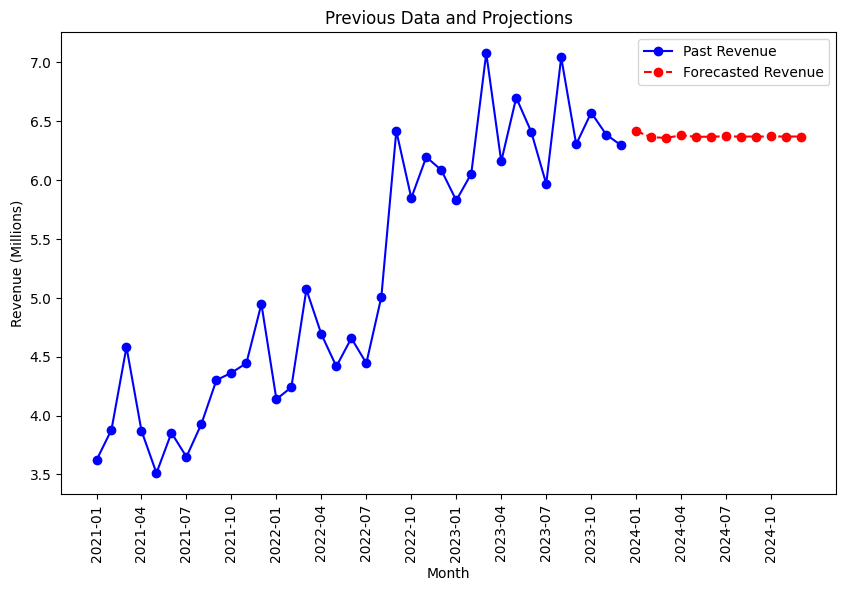

In [31]:
plt.figure(figsize=(10, 6))

# Adjust the data by dividing by 1 million to convert to millions
past_revenue = output_data.sum().values[0:-NUMBER_OF_MONTHS] / 1e6
forecasted_revenue = output_data.sum().values[-NUMBER_OF_MONTHS:] / 1e6

# Plotting the past revenue
plt.plot(output_data.columns[0:-NUMBER_OF_MONTHS], past_revenue, color='blue', marker='o', linestyle='-', label='Past Revenue')
# Plotting the forecasted revenue
plt.plot(output_data.columns[-NUMBER_OF_MONTHS:], forecasted_revenue, color='red', marker='o', linestyle='--', label='Forecasted Revenue')

plt.title('Previous Data and Projections')
plt.xlabel('Month')
plt.ylabel('Revenue (Millions)')
plt.xticks(output_data.columns[0::3], rotation=90)  # Adjust x-axis ticks

# Adding the legend to the plot
plt.legend()

# Show the plot
plt.show()